In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os
from scipy.interpolate import interp1d
import healpy as hp
from scipy import stats

# Fourier space measurements Gaussian sims

In [44]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [45]:
nside = 4096

dir = '../data_vectors/gaussian_sims/071222/area12300/July14/'

make_directory(dir + 'plots')

file = 'analytic_noise/twopoint_data_fourier.sacc'
a = sacc.Sacc.load_fits(dir+file)
a_name = 'analytic'

file = 'twopoint_theory_fourier.sacc'
t = sacc.Sacc.load_fits(dir+file)

file = 'twopoint_theory_fourier_no_bin_averaging.sacc'
t_nba = sacc.Sacc.load_fits(dir+file)

file = 'analytic_noise/summary_statistics_fourier.sacc'
t_cov = sacc.Sacc.load_fits(dir+file)

file = 'analytic_noise/summary_statistics_fourier_tjpcov.sacc'
t_cov_tjp = sacc.Sacc.load_fits(dir+file)

dir2 = '../data_vectors/gaussian_sims/071222_run2/area12300/July14/'

make_directory(dir2 + 'plots')

file = 'analytic_noise/twopoint_data_fourier_shot_noise_scaled.sacc'
a2 = sacc.Sacc.load_fits(dir2+file)
a_name = 'analytic'

file = 'twopoint_theory_fourier.sacc'
t2 = sacc.Sacc.load_fits(dir2+file)

file = 'analytic_noise/summary_statistics_fourier_shot_noise_scaled.sacc'
t2_cov = sacc.Sacc.load_fits(dir2+file)


W = "galaxy_density_xi"
GAMMA = "galaxy_shearDensity_xi_t"
GAMMAX = "galaxy_shearDensity_xi_x"
XIP = "galaxy_shear_xi_plus"
XIM = "galaxy_shear_xi_minus"
EE = "galaxy_shear_cl_ee"
DD = "galaxy_density_cl"
ED = "galaxy_shearDensity_cl_e"


c = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']

## Define scale cuts and simulation scaling factor

In [46]:
# Redshift bins
nsbins = 5
nlbins = 5

# Scaling factor for the gaussian sims
#sims_factor = np.array([2.458, 2.043, 1.878, 2.060, 2.249])
sims_factor = np.ones(nlbins)

# GGL and clustering cuts as computed in https://github.com/LSSTDESC/txpipe-cosmodc2/blob/master/notebooks/ScaleCutsSRD.ipynb
lmax_zl = [252.27086242, 401.05572005, 534.43202612, 653.61625038, 760.14254387] 
lmax_cs = 3000 #lmax for cosmic shear

#from https://github.com/CosmoLike/DESC_SRD/blob/master/gglensing_zbin_y1
GGL_combinations_dict = {
    'zl0zs0': 0,
    'zl0zs1': 0,
    'zl0zs2': 1,
    'zl0zs3': 1,
    'zl0zs4': 1,
    'zl1zs0': 0,
    'zl1zs1': 0,
    'zl1zs2': 0,
    'zl1zs3': 1,
    'zl1zs4': 1,
    'zl2zs0': 0,
    'zl2zs1': 0,
    'zl2zs2': 0,
    'zl2zs3': 0,
    'zl2zs4': 1,
    'zl3zs0': 0,
    'zl3zs1': 0,
    'zl3zs2': 0,
    'zl3zs3': 0,
    'zl3zs4': 1,
    'zl4zs0': 0,
    'zl4zs1': 0,
    'zl4zs2': 0,
    'zl4zs3': 0,
    'zl4zs4': 0}

## Build saac simulated data file with theory and covariance

In [34]:
t.get_data_types()
t.remove_selection('galaxy_shear_cl_be')
t.remove_selection('galaxy_shear_cl_eb')

In [36]:
cov_f = t_cov.covariance.dense
t.add_covariance(cov_f)
t.save_fits(dir+'twopoint_theory_fourier_with_cov.sacc', overwrite=True)

## Plot bandpowers for sources

In [37]:
ind = a.indices("galaxy_shear_cl_ee", (f"source_0", f"source_0"))
print(ind)
bpw = a.get_bandpower_windows(ind)

[1760 1761 1762 1763 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773
 1774 1775]


Text(0, 0.5, 'TXPipe Bandpowers')

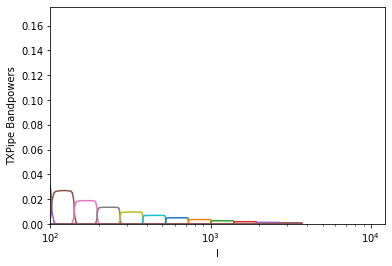

In [38]:
plt.plot(bpw.values, bpw.weight)#, 'royalblue')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(100, 3*nside)
plt.ylim(ymin=0)
plt.xlabel('l')
plt.ylabel('TXPipe Bandpowers')

## Compare theory with measurements

In [47]:
def get_mean(s, dts, factor, lmax): 
    mean = []
    thetas = []
    masks = []
    for dt in dts:
        dps = s.get_data_points(dt)
        for dp in dps:
            # this will be the lens when clustering and gglensing. Source when cosmic shear. 
            bin = int(dp.tracers[1][-1])
            
            if dp['ell']<lmax_cs: #always cut below 3000.

                if dt == ED:
                    source_bin = int(dp.tracers[0][-1])
                    lens_bin = int(dp.tracers[1][-1])
                    factor_i = factor[lens_bin]
                    if GGL_combinations_dict['zl%dzs%d'%(lens_bin, source_bin)] and dp['ell']<lmax[bin]: #SRD requirements
                    #if lens_bin<=source_bin:
                        mean.append(dp.value*factor_i)
                        mask = True
                    else:
                        mask = False

                if dt == DD:
                    lens_bin1 = int(dp.tracers[0][-1])
                    lens_bin2 = int(dp.tracers[1][-1])
                    if lens_bin1==lens_bin2 and dp['ell']<lmax[bin]: 
                        factor_1 = factor[lens_bin1]
                        factor_2 = factor[lens_bin2]
                        mean.append(dp.value*factor_1*factor_2)
                        mask = True
                    else:
                        mask = False
                if dt == EE:
                    mean.append(dp.value)
                    mask = True

            else:
                mask = False

            masks.append(mask)
    mean = np.array(mean)
    masks = np.array(masks)
    return mean, masks

def get_cov(s, dts):
    inds = []
    for dt in dts:
        inds.extend(s.indices(dt))
    cov = s.covariance.get_block(inds)
    return cov
    
def compute_chi2_gauss(data, theory, cov_th, dt, factor = np.ones(nlbins), lmax=None):
    #print('Cutting scales larger than', lmax)
    theory_mean, mask = get_mean(theory, dt, factor = np.ones(nlbins), lmax=lmax)
    data_mean, mask = get_mean(data, dt, factor, lmax=lmax)

    cov = get_cov(cov_th, dt)
    cov = (cov[mask]).T[mask]
    invcov = np.linalg.inv(cov) 
    
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    ndf = len(data_mean)
    pvalue = 1 - stats.chi2.cdf(deltachi2, ndf)
    
    return deltachi2, ndf, pvalue, cov, theory_mean

In [49]:
print('With TXFourierGaussianCovariance')

chi2, ndf, pvalue, cov, _= compute_chi2_gauss(a, t, cov_th = t_cov, dt = [EE], lmax = None)
print('shear cl (srd cuts): chi2/ndf = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov, _ = compute_chi2_gauss(a, t,cov_th = t_cov, dt = [ED], factor = sims_factor, lmax = lmax_zl)
print('galaxy-shear cl (srd cuts): chi2/ndf = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov, _= compute_chi2_gauss(a, t, cov_th = t_cov, dt = [DD], factor = sims_factor, lmax = lmax_zl)
print('galaxy cl (srd cuts): chi2/ndf  = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov, t_mean = compute_chi2_gauss(a, t, cov_th = t_cov, dt = [DD, ED, EE], factor = sims_factor, lmax = lmax_zl)
print('total (srd cuts): chi2/ndf = %0.1f/%d = %0.2f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

With TXFourierGaussianCovariance
shear cl (srd cuts): chi2/ndf = 232.8/225 = 1.03, p-value = 0.35
galaxy-shear cl (srd cuts): chi2/ndf = 75.3/63 = 1.20, p-value = 0.14
galaxy cl (srd cuts): chi2/ndf  = 55.5/49 = 1.13, p-value = 0.24
total (srd cuts): chi2/ndf = 383.2/337 = 1.14, p-value = 0.04


In [7]:
print('With TJPCovCovariance')

chi2, ndf, pvalue, cov = compute_chi2_gauss(a, t, cov_th = t_cov_tjp, dt = [EE], lmax = None)
print('shear cl (srd cuts): chi2/ndf = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov = compute_chi2_gauss(a, t,cov_th = t_cov_tjp, dt = [ED], factor = sims_factor, lmax = lmax_zl)
print('galaxy-shear cl (srd cuts): chi2/ndf = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov = compute_chi2_gauss(a, t, c                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ov_th = t_cov_tjp, dt = [DD], factor = sims_factor, lmax = lmax_zl)
print('galaxy cl (srd cuts): chi2/ndf  = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov = compute_chi2_gauss(a, t, cov_th = t_cov_tjp, dt = [DD, ED, EE], factor = sims_factor, lmax = lmax_zl)
print('total (srd cuts): chi2/ndf = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

With TJPCovCovariance
shear cl (srd cuts): chi2/ndf = 205.1/225 = 0.9, p-value = 0.83
galaxy-shear cl (srd cuts): chi2/ndf = 64.6/63 = 1.0, p-value = 0.42
galaxy cl (srd cuts): chi2/ndf  = 48.0/49 = 1.0, p-value = 0.51
total (srd cuts): chi2/ndf = 330.1/337 = 1.0, p-value = 0.60


In [45]:
print('With TXFourierGaussianCovariance')

chi2, ndf, pvalue, cov = compute_chi2_gauss(a2, t2, cov_th = t2_cov, dt = [EE], lmax = None)
print('shear cl (srd cuts): chi2/ndf = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov = compute_chi2_gauss(a2, t2,cov_th = t2_cov, dt = [ED], factor = sims_factor, lmax = lmax_zl)
print('galaxy-shear cl (srd cuts): chi2/ndf = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov = compute_chi2_gauss(a2, t2, cov_th = t2_cov, dt = [DD], factor = sims_factor, lmax = lmax_zl)
print('galaxy cl (srd cuts): chi2/ndf  = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

chi2, ndf, pvalue, cov = compute_chi2_gauss(a2, t2, cov_th = t2_cov, dt = [DD, ED, EE], factor = sims_factor, lmax = lmax_zl)
print('total (srd cuts): chi2/ndf = %0.1f/%d = %0.1f, p-value = %0.2f'%(chi2,ndf, chi2/ndf, pvalue))

With TJPCovCovariance
shear cl (srd cuts): chi2/ndf = 253.9/270 = 0.9, p-value = 0.75
galaxy-shear cl (srd cuts): chi2/ndf = 5422.7/60 = 90.4, p-value = 0.00
galaxy cl (srd cuts): chi2/ndf  = 115240.8/49 = 2351.9, p-value = 0.00
total (srd cuts): chi2/ndf = 124077.1/379 = 327.4, p-value = 0.00


# Make the measurement plots here

In [8]:
def plot_twopoint(s, theory=None, theory_cov = None, s2 =None, datatype=None, ratios = False, diff = False, diff_with_errors=False, plot_noise=False):

        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                    if s2 is not None:
                        ell2, cl2 = s2.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))

                    n_ell_analytic = s.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )

                    if i>=j:
                        if datatype == ED:
                            cl = cl*sims_factor[j]
                            if s2 is not None:
                                cl2 = cl2*sims_factor[j]
                        if datatype == DD:
                            cl = cl*sims_factor[j]*sims_factor[i]
                            if s2 is not None:
                                cl2 = cl2*sims_factor[j]*sims_factor[i]

                        if theory_cov is not None:
                            _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err = np.sqrt(np.diag(cov))  
                    
                        if theory is not None:
                            ell_th, cl_th = theory.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)
                        if ratios:
                            if len(cl_th[cl_th==0])==0:
                                ax[i][j].errorbar(ell, cl/cl_th, err/cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement/Theory')
                                if s2 is not None:
                                    ax[i][j].plot(ell, cl2/cl, '-',  lw = 2,  color = c[2], label = 'Measurements Yuuki/Measurements')
                        elif diff:
                            ax[i][j].errorbar(ell, cl-cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                            ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')

                        else:
                            ax[i][j].plot(ell, cl_th, ls = '-', lw = '1.5', color = c[1], label = 'Theory')
                            ax[i][j].errorbar(ell, cl, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurements')
                            if s2 is not None:
                                ax[i][j].errorbar(ell2, cl2, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[3], label = 'Measurements Yuuki')
                            if plot_noise:
                                if i==j:
                                    if datatype == EE:

                                        ax[i][j].plot(ell, np.array(n_ell_analytic), ls = ':', lw = '2.', color = c[1], label = r'TXPipe noise analytic decoupled ')
                                    if datatype == DD:

                                        ax[i][j].plot(ell, np.array(n_ell_analytic)*sims_factor[j]**2, ls = ':', lw = '1.5', color = c[1], label = r'TXPipe noise analytic decoupled $\times f_{sims}^2$')

                        if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                            ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                        verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(20, 3000)
                    #ax[k][j].axvspan(lmax_zl, 6000, color='lightgrey', alpha = 0.3)

                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==EE:
                            ax[i][j].set_ylim(10**(-12), 10**(-8))
                        if datatype==ED:
                            ax[i][j].set_ylim(10**(-10), 6*10**(-7))
                        if datatype==DD:
                            ax[i][j].set_ylim(10**(-8), 10**(-3))                            

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$C_{\gamma \gamma}(\ell)$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$C_{\delta \gamma}(\ell)$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$C_{\delta \delta}(\ell)$')

                            
                    if i<j:
                        fig.delaxes(ax[i, j])
    

    return fig


galaxy_shear_cl_ee


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

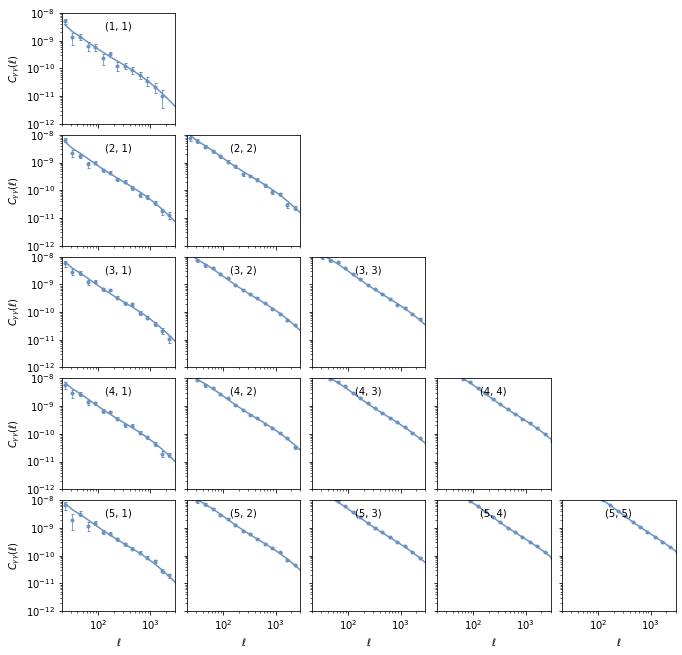

In [47]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov_tjp, datatype=EE, ratios = False, diff = False, diff_with_errors = False,plot_noise=False)
plt.savefig(dir + 'plots/' + 'cl_shear_tjp_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

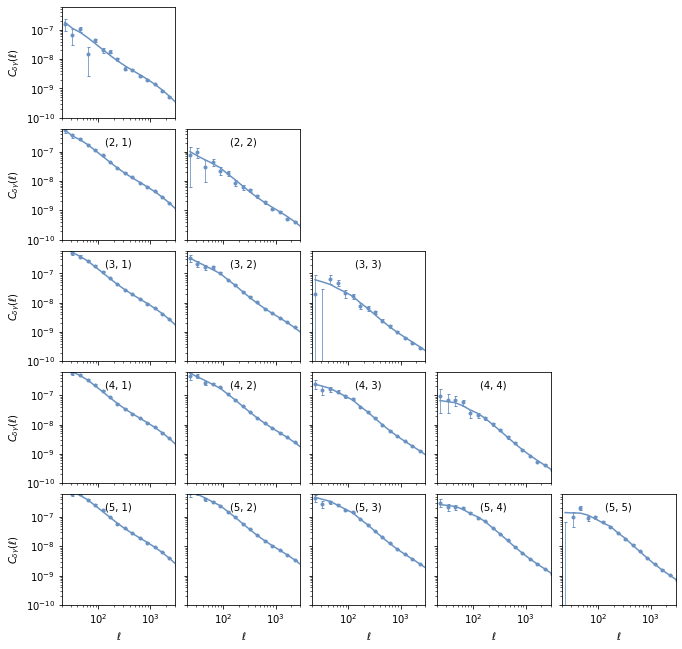

In [48]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov_tjp, datatype=ED, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_tjp_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

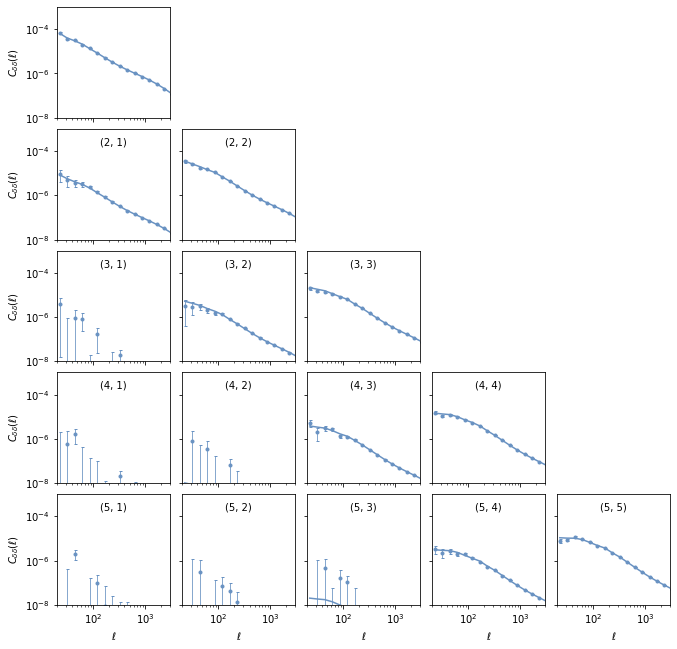

In [9]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov_tjp, datatype=DD, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_tjp%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


<Figure size 432x288 with 0 Axes>

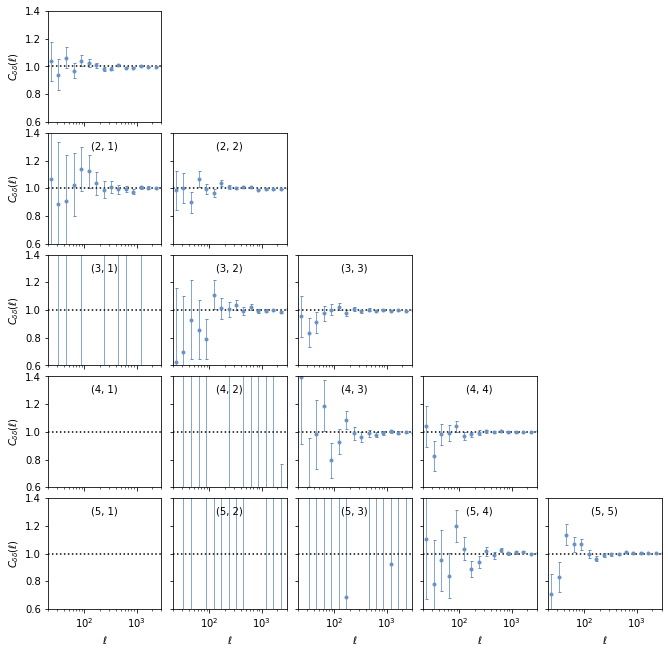

In [50]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov_tjp, datatype=DD, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_tjp_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_cl_ee


<Figure size 432x288 with 0 Axes>

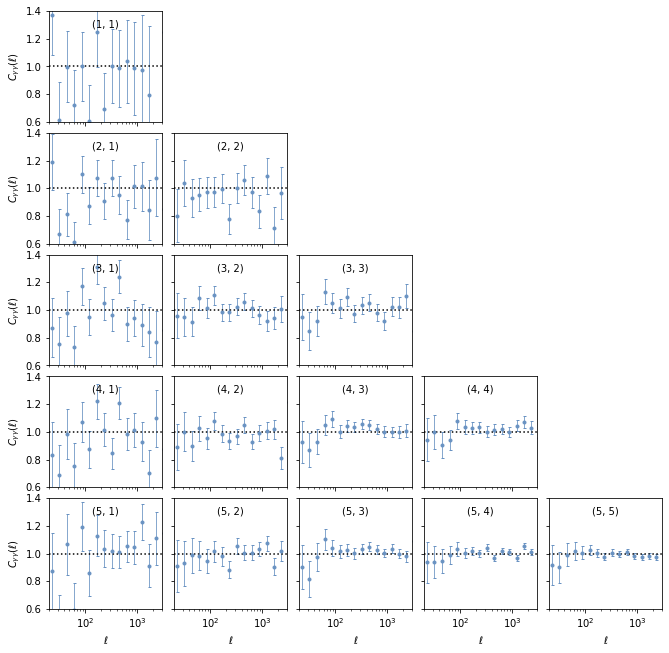

In [51]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov_tjp, datatype=EE, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_shear_tjp_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

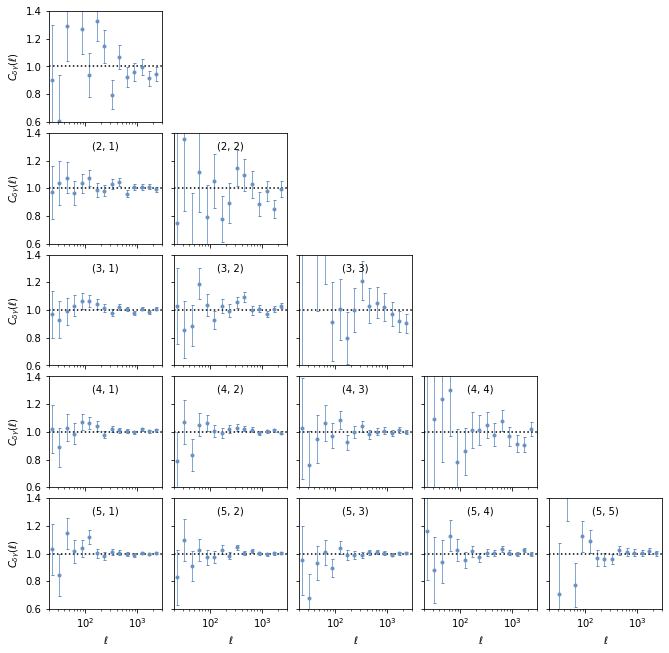

In [52]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov_tjp, datatype=ED, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_tjp_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

In [57]:
def plot_errorbars(s, theory_cov = None,  theory_cov2 = None, datatype=None, ratios = False):
      
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            
            for i in range(nbins1):
                for j in range(nbins2):

                    ell, _ = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                    if i>=j:

                        if theory_cov is not None:
                            # this returns the theory cov, and overwrites the error if theory_cov is not None
                            _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err = np.sqrt(np.diag(cov))  
                            
                        if theory_cov2 is not None:
                            _, _, cov2 = theory_cov2.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err2 = np.sqrt(np.diag(cov2))  
                    
                        if not ratios:
                            ax[i][j].plot(ell, err, ls = '-', lw = '1.5', color = c[1], label = 'TXFourierGaussianCov')
                            if theory_cov2 is not None:
                                ax[i][j].plot(ell, err2, ls = '-', lw = '1.5', color = c[3], label = 'TXFourierTJPCov')

                        if ratios:
                            ax[i][j].plot(ell, err2/err, ls = '-', lw = '1.5', color = c[1], label = 'TXFourierTJPCov/TXFourierGaussianCov')

                        if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                            ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                        verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                            
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(20, 3000)
                    if not ratios:
                        ax[i][j].set_yscale('log')
                    if ratios:
                        
                        ax[i][j].set_ylim(0.9, 1.5)
                        ax[i][j].axhline(y=1, color = 'k', ls= ':')
                        

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$\sigma (C_{\gamma \gamma})$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$\sigma (C_{\delta \gamma})$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$\sigma (C_{\delta \delta})$')

                    if i<j:
                        fig.delaxes(ax[i, j])
    
    ax[0][0].legend(frameon = False, loc = 'best', bbox_to_anchor=(2., 0.5, 0.5, 0.5))

    return fig


galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

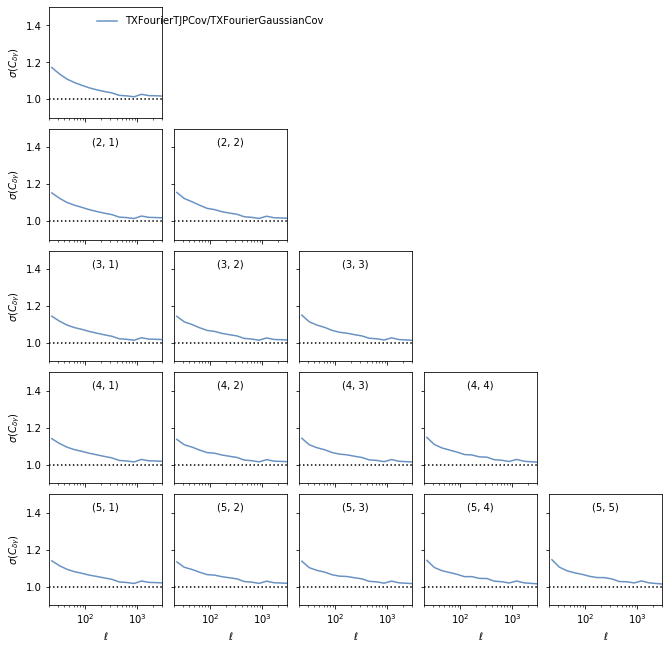

In [60]:
fig = plot_errorbars(a, theory_cov = t_cov,  theory_cov2 = t_cov_tjp, datatype=ED, ratios = True)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_error_tjp_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

In [20]:
def plot_twopoint_theory(s, theory=None, theory_cov = None, datatype=None, ratios = False, diff = False, diff_with_errors=False):

        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                    if theory_cov is not None:
                        # this returns the theory cov, and overwrites the error if theory_cov is not None
                        _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err = np.sqrt(np.diag(cov))  
                    
                    if theory is not None:
                        ell_th, cl_th = theory.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)
                    if ratios:
                        if len(cl_th[cl_th==0])==0:
                            ax[i][j].errorbar(ell, cl/cl_th, err/cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Theory binned properly/Theory')
                    elif diff:
                        ax[i][j].errorbar(ell, cl-cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                        ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')

                    else:
                        ax[i][j].plot(ell, cl_th, ls = '-', lw = '1.5', color = c[1], label = 'Theory')
                        ax[i][j].errorbar(ell, cl, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Theory binned properly')

                    if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                        ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                    verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(100, 2*nside)

                    if ratios:
                        ax[i][j].set_ylim(0.95, 1.05)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==EE:
                            ax[i][j].set_ylim(8*10**(-12), 10**(-8))
                        if datatype==ED:
                            ax[i][j].set_ylim(8*10**(-11), 10**(-7))
                        if datatype==DD:
                            ax[i][j].set_ylim(10**(-9), 10**(-5))                            

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$C_{\gamma \gamma}(\ell)$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$C_{\delta \gamma}(\ell)$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$C_{\delta \delta}(\ell)$')

                            
                    #if datatype!=ED:
                    if i<j:
                        fig.delaxes(ax[i, j])
    
    ax[0][0].legend(frameon = False, loc = 'best')

    return fig
